# Kagome lattice groud state energy estimation using VQE algorithm with differential evolution optimizer.

## Introduction
This project is a didactic approach of the IBM Quantum Awards: Open Science Prize 2022 problem and it was developed in a student internship at CESGA (Centro de Supuercomputación de Galicia) during July 2023 using the Finisterrae3 supercomputer to run the quantum circuit simulations.

Open Science Prize 2022 GitHub: https://github.com/qiskit-community/open-science-prize-2022

The objective was to prepare an ansatz that maps the state space with as much efficiency as possible, as a resul, it will have many layers and thus not be able to run in a real quantum computer. We intend to see that this kind of computation is theorically able to obtain the exact gound state energy of the lattice.




Firstly, we will import all the needed libraries.

In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import rustworkx as rx

import sys
import os
import time
import warnings
warnings.filterwarnings('ignore')

from heisenberg_model import HeisenbergModel

from qiskit_nature.problems.second_quantization.lattice import Lattice
from qiskit_nature.mappers.second_quantization import LogarithmicMapper
from qiskit.algorithms import NumPyEigensolver
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit_aer import AerSimulator

import dask
from distributed import Client
import dask.array as da

from kagome_custom import custom_VQE
from qiskit.primitives import Estimator





## Kagome lattice representation and exact values of the system eigenvalues
This representation of the Kagome lattices is a modification of the one in the Open Science Prize 2022 GitHub that uses 16 qubits to work in the Guadalupe quantum computer, for simplicity, we will only work with 12 qubits.

The Kagome lattice contains 12 $\frac{1}{2}$-spins, half of them with 4 neighbours and the other half with 2. This heterogeneus connectivity makes que computation of the ground state energy harder tha in an Ising chain.

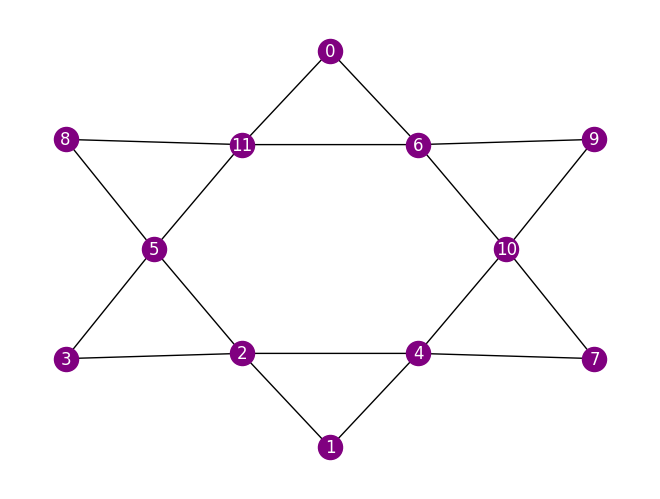

In [2]:
num_qubits = 12
t = 1.0

graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_qubits))
edge_list = [
    (1, 2, t),
    (2, 3, t),
    (3, 5, t),
    (5, 8, t),
    (8, 11, t),
    (11, 0, t),
    (0, 6, t),
    (6, 9, t),
    (9, 10, t),
    (10, 7, t),
    (7, 4, t),
    (4, 1, t),
    (4, 2, t),
    (2, 5, t),
    (5, 11, t),
    (11, 6, t),
    (6, 10, t),
    (10, 4, t),
]

graph.add_edges_from(edge_list)
kagome_unit_cell = Lattice(graph)

kagome_pos = {0:[0,6.8], 6:[0.6,5], 9:[1.8,5.1], 
              1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
              11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
              8:[-1.8,5.1], 7:[1.8,0.9]}
kagome_unit_cell.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':kagome_pos})
plt.show()

We will study the Kagome lattice with a Heisenberg model for the energy with antiferromagnetic order ($J<0$) only with neighbour interaction (no magnetic field applied), the ground state of the ferromagnetic case (J>0) is easier. The Hamiltonian of this system is:

$$H =-J\sum_{i\neq j}{(X_iX_j+Y_iY_j+Z_iZ_j)}$$

Where $X_i$, $Y_i$ and $Z_i$ are the Pauli operators and each term of the summatory is an operator in a $2^{12}$-dimensional Hilbert, the index indicates the qubits where the Pauli operator are being applied.

We used the heisenberg_model.py script from the Open Science Prize 2022 GitHub to have a look at the Pauli Strings. We can see that we got 3 conmutation groups, one for each spatial dimension, this characteristic will make the energy estimation easier, because it will be possible to compute the energy of each spatial dimension with the same function, making the proccess parallelizable. As we can see, each term of the Pauli strings is a tensor product of two Pauli operators, where the qubits interacting are, and identity operators in the rest of them.


In [3]:
heis = HeisenbergModel.uniform_parameters(lattice=kagome_unit_cell,uniform_interaction=1.0,uniform_onsite_potential=0.0)
log_mapper = LogarithmicMapper()
ham=4*log_mapper.map(heis.second_q_ops().simplify())
ham



PauliSumOp(SparsePauliOp(['IZZIIIIIIIII', 'ZIIZIIIIIIII', 'IZIIZIIIIIII', 'ZIIIIZIIIIII', 'IZIIIZIIIIII', 'IIZIIZIIIIII', 'ZIIIIIZIIIII', 'IIIZIIZIIIII', 'IZIIIIIZIIII', 'IIIIZIIZIIII', 'IIIIIIZIZIII', 'IIIIIIZIIZII', 'IIIIIIIZIZII', 'IIIIIIIIZZII', 'IIIIIIIZIIZI', 'IIIIIIIIIZZI', 'ZIIIIIIIIIIZ', 'IIIIIZIIIIIZ', 'IYYIIIIIIIII', 'YIIYIIIIIIII', 'IYIIYIIIIIII', 'YIIIIYIIIIII', 'IYIIIYIIIIII', 'IIYIIYIIIIII', 'YIIIIIYIIIII', 'IIIYIIYIIIII', 'IYIIIIIYIIII', 'IIIIYIIYIIII', 'IIIIIIYIYIII', 'IIIIIIYIIYII', 'IIIIIIIYIYII', 'IIIIIIIIYYII', 'IIIIIIIYIIYI', 'IIIIIIIIIYYI', 'YIIIIIIIIIIY', 'IIIIIYIIIIIY', 'IXXIIIIIIIII', 'XIIXIIIIIIII', 'IXIIXIIIIIII', 'XIIIIXIIIIII', 'IXIIIXIIIIII', 'IIXIIXIIIIII', 'XIIIIIXIIIII', 'IIIXIIXIIIII', 'IXIIIIIXIIII', 'IIIIXIIXIIII', 'IIIIIIXIXIII', 'IIIIIIXIIXII', 'IIIIIIIXIXII', 'IIIIIIIIXXII', 'IIIIIIIXIIXI', 'IIIIIIIIIXXI', 'XIIIIIIIIIIX', 'IIIIIXIIIIIX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j

We will obtain the exact ground state energy of the lattice to see the value we aim to reach with our method.

In [4]:
exact_solver = NumPyEigensolver(k=50)
exact_result = exact_solver.compute_eigenvalues(ham)

gs_energy = np.round(exact_result.eigenvalues[0], 4)
print('Real ground state energy: ' + str(gs_energy))

Real ground state energy: -18.0


This system has a high degeneration on its excited states wich makes more probable to fall in a relative minimun.

In [5]:
print('First 20 eigenstates with the lowest energies: ')
print(str(exact_result.eigenvalues[0:49]))

First 20 eigenstates with the lowest energies: 
[-18.         -18.         -16.96132284 -16.96132284 -16.96132284
 -16.94488902 -16.94488902 -16.94488902 -16.94488902 -16.94488902
 -16.94488902 -16.92960648 -16.92960648 -16.92960648 -16.92960648
 -16.92960648 -16.92960648 -16.80979384 -16.80979384 -16.80979384
 -16.73525336 -16.72928939 -16.72928939 -16.56740607 -16.56740607
 -16.31171211 -16.31171211 -16.31171211 -16.27540017 -16.27540017
 -16.27540017 -16.27540017 -16.27540017 -16.27540017 -16.22588905
 -16.04123404 -16.04123404 -16.04123404 -16.04123404 -16.04123404
 -16.04123404 -15.65386148 -15.65386148 -15.65386148 -15.4600591
 -15.4600591  -15.33076284 -15.33076284 -15.33076284]


## Custom VQE 
We divided our method in three parts:

- Quantum circuit: Initial state and Ansatz
- Measurement simulation by shots and Energy estimation
- Differential evolution optimizer

VQE algorithms are hibrid algorithms, they are a combination of a parametrized quantum circuit that has some information about the system of study and an optimazer that creates new values to evaluate in order to reach some minimum of a cost function.


In our case, the cost function is the energy evaluation of the resultant state from the quantum circuit.

### Quantum circuit
The objective of the quantum circuit is to map the parameter space in meaninful way to the Hamiltonian of the system, i.e., it reduces the search space that the optimazer has to navigate in order to get to the energy minimum. This is achieved, for example, if our circuit can produce eigenstates for the Hamiltonian, thus removing many states that can not be the ground state.

We are going to divide the quantum circuit in three parts:
- Initialization
- Ansatz
- Measurement

#### Initialization and ansatz
We chose a ground state of the Ising model for the Kagome lattice along the Z axis. The explanation for this choice will be explained next because it is optimal for the chosen ansatz.

In [6]:
def add_init_state(circuit, down_list): 
    for i in down_list:
        circuit.x(i)
    return circuit


qc = QuantumCircuit(num_qubits, num_qubits)
down_list = [11,10,2] 
qc = add_init_state(qc,down_list)
        

In [7]:
def add_init_state(circuit, down_list): # Adds the selected initial state, corresponds to one of the Z-Ising model kagome's grounds states 
    for i in down_list:
        circuit.x(i)
    return circuit
        
def add_edge_gates(qa,edge,var,param,p): # Adds the RXX, RYY and RZZ for each interaction present in the system's Hamiltonian
    [n1, n2] = [edge[0],edge[1]]
    if var == 0:
        qa.h(n1)
        qa.h(n2)
    elif var == 1:
        qa.s(n1)
        qa.h(n1)
        qa.s(n2)
        qa.h(n2)
        
    qa.cx(n1,n2)
    phi = param[var+3*p]
    qa.rz(phi, n2)
    qa.cx(n1,n2)
    
    if var == 0:
        qa.h(n1) 
        qa.h(n2)
    elif var == 1:
        qa.h(n1)
        qa.s(n1)
        qa.h(n2)
        qa.s(n2)
    return qa

def build_ansatz(num_param,layers,edge_list): # Builds the complete ansatz, composed of 6 layers, each one with the 18 interactions of the Kagome lattice for the 3 spatial dimensions
    param = []
    for k in range(num_param): # Creates a list of the parameters used in the rotation gates
        param.append(Parameter('θ_' + str(k)))

    ansatz = QuantumCircuit(num_qubits,name='ansatz') 
    
    ansatz.barrier()
    for k in range(layers):
        for i in range(3):
            for edge in edge_list:
                ansatz.barrier()
                add_edge_gates(ansatz,edge,i,param,k) #Adds the RXX, RYY and RZZ gates by layers
    ansatz.barrier()
    return ansatz

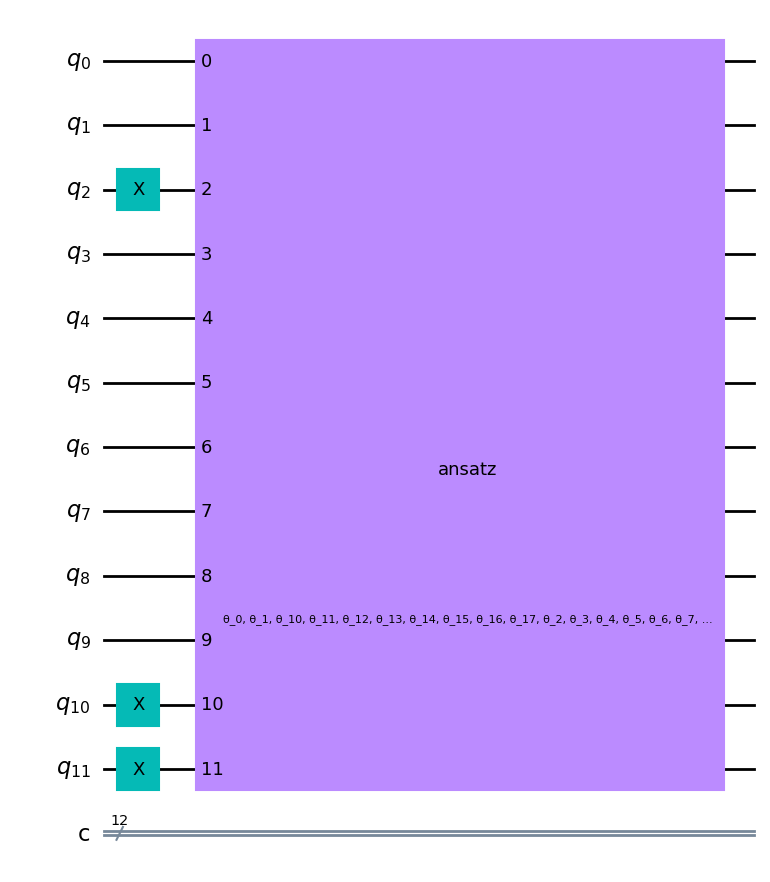

In [8]:
# Construction of the main quantum circuit
qc = QuantumCircuit(num_qubits, num_qubits)
down_list = [11,10,2] # List of the qubits that are reverted in the chosen initial state
qc = add_init_state(qc,down_list)
layers = 6
num_param = 3 * layers
ansatz = build_ansatz(num_param,layers,edge_list)
qc.append(ansatz, range(num_qubits))
qc.draw('mpl',fold=-1)


  

Let's have a look at the ansatz:

In [9]:
ansatz.draw(fold=-1) # Due to its deepness, do not use the 'mpl' option for .draw()

░  ░                                 ░                                 ░                                 ░                                 ░                                 ░ ┌───┐┌───┐┌─────────┐┌───┐┌───┐ ░ ┌───┐                     ┌───┐ ░                                 ░                                 ░                                 ░                                 ░                                 ░                                 ░                                 ░                                 ░                                 ░                                 ░                                 ░                                           ░                                           ░                                           ░                                           ░                                           ░ ┌───┐┌───┐┌───┐┌─────────┐┌───┐┌───┐┌───┐ ░ ┌───┐┌───┐                     ┌───┐┌───┐ ░                                           ░                                           ░                                           ░                                           ░                                           ░                                           ░                                           ░                                           ░                                           ░                                           ░                                           ░                       ░                       ░                       ░                       ░                       ░ ┌───┐┌─────────┐┌───┐ ░                       ░                       ░                       ░                       ░                       ░                       ░                       ░                       ░                       ░                       ░                       ░                       ░                                 ░                                 ░                                 ░                                 ░                                 ░ ┌───┐┌───┐┌─────────┐┌───┐┌───┐ ░ ┌───┐                     ┌───┐ ░                                 ░                                 ░                                 ░                                 ░                                 ░                                 ░                                 ░                                 ░                                 ░                                 ░                                 ░                                           ░                                           ░                                           ░                                           ░                                           ░ ┌───┐┌───┐┌───┐┌─────────┐┌───┐┌───┐┌───┐ ░ ┌───┐┌───┐                     ┌───┐┌───┐ ░                                           ░                                           ░                                           ░                                           ░                                           ░                                           ░                                           ░                                           ░                                           ░                                           ░                                           ░                       ░                       ░                       ░                       ░                       ░ ┌───┐┌─────────┐┌───┐ ░                       ░                       ░                       ░                       ░                       ░                       ░                       ░                       ░                       ░                       ░                       ░                       ░                                 ░                                 ░                                 ░                                 ░                                 ░ ┌───┐┌───┐┌─────────┐┌───┐┌───┐ ░ ┌───┐                     ┌───┐ ░                                 ░                                 ░                  

#### Measurements

The Hamiltonian has independent terms for each axis, so, with some basis changes, we can calculate the energy for each axis. Let's have a look at the circuits

In [10]:
def build_measure_circuits(qc,num_qubits):
    qc_meas = [None, None, None]
    for j in range(3):
        qc_meas[j] = qc.copy()
        for i in range(num_qubits):
            if j == 0:
                qc_meas[j].h(i)

            elif j == 1:
                qc_meas[j].s(i)
                qc_meas[j].h(i)
                qc_meas[j].x(i)



            qc_meas[j].measure(i,i)
    return qc_meas

In [11]:
qc_meas = build_measure_circuits(qc,num_qubits)
[qcx,qcy,qcz] = qc_meas

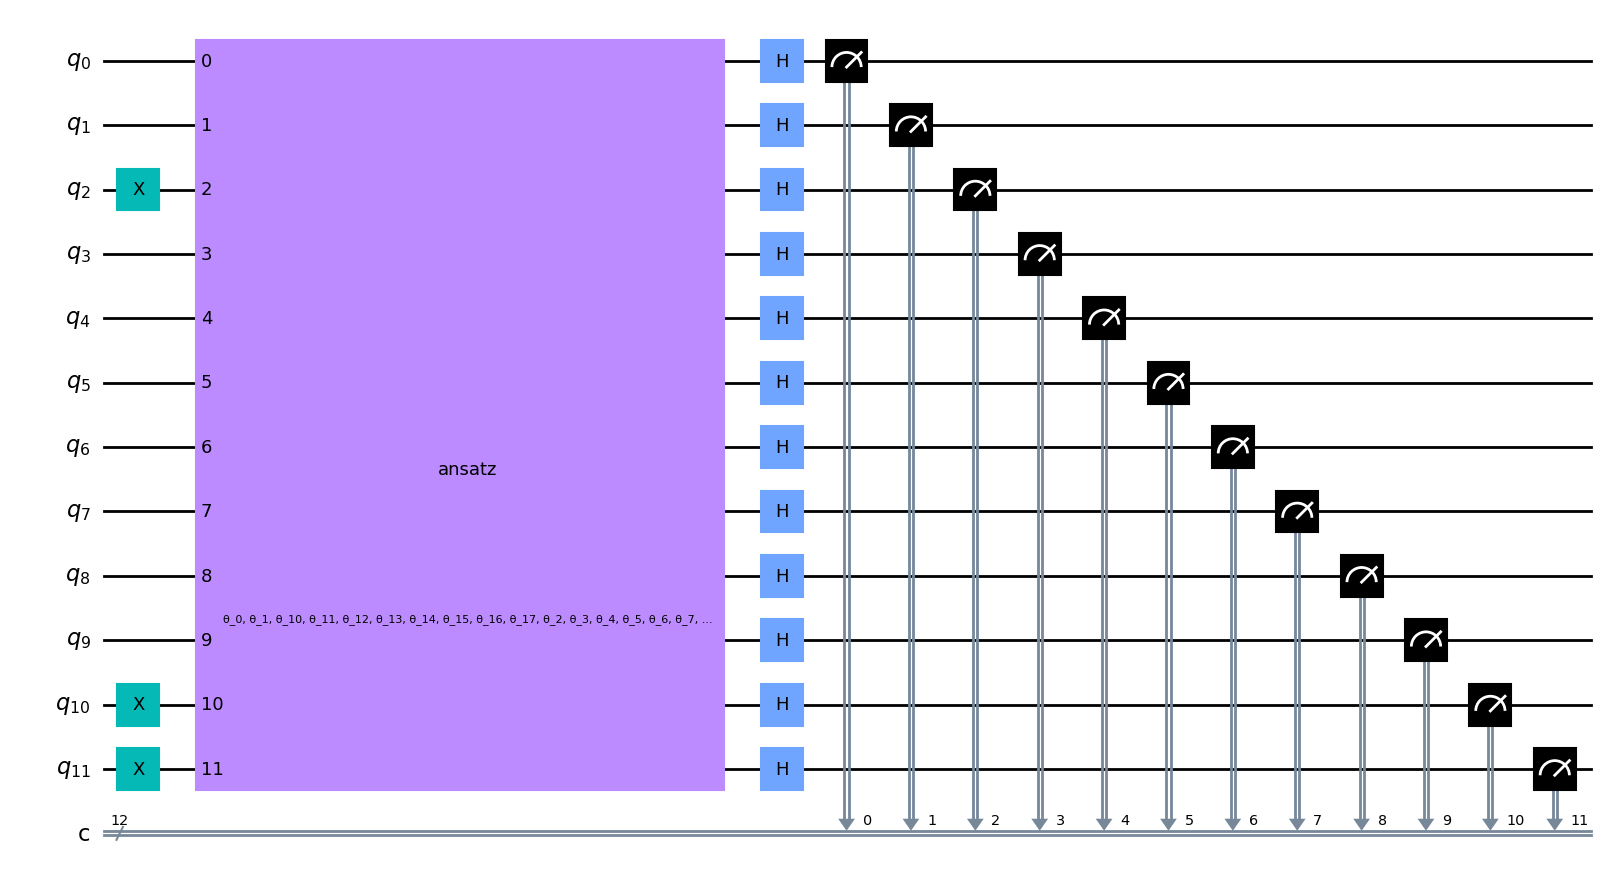

In [12]:
qcx.draw('mpl',fold=-1)

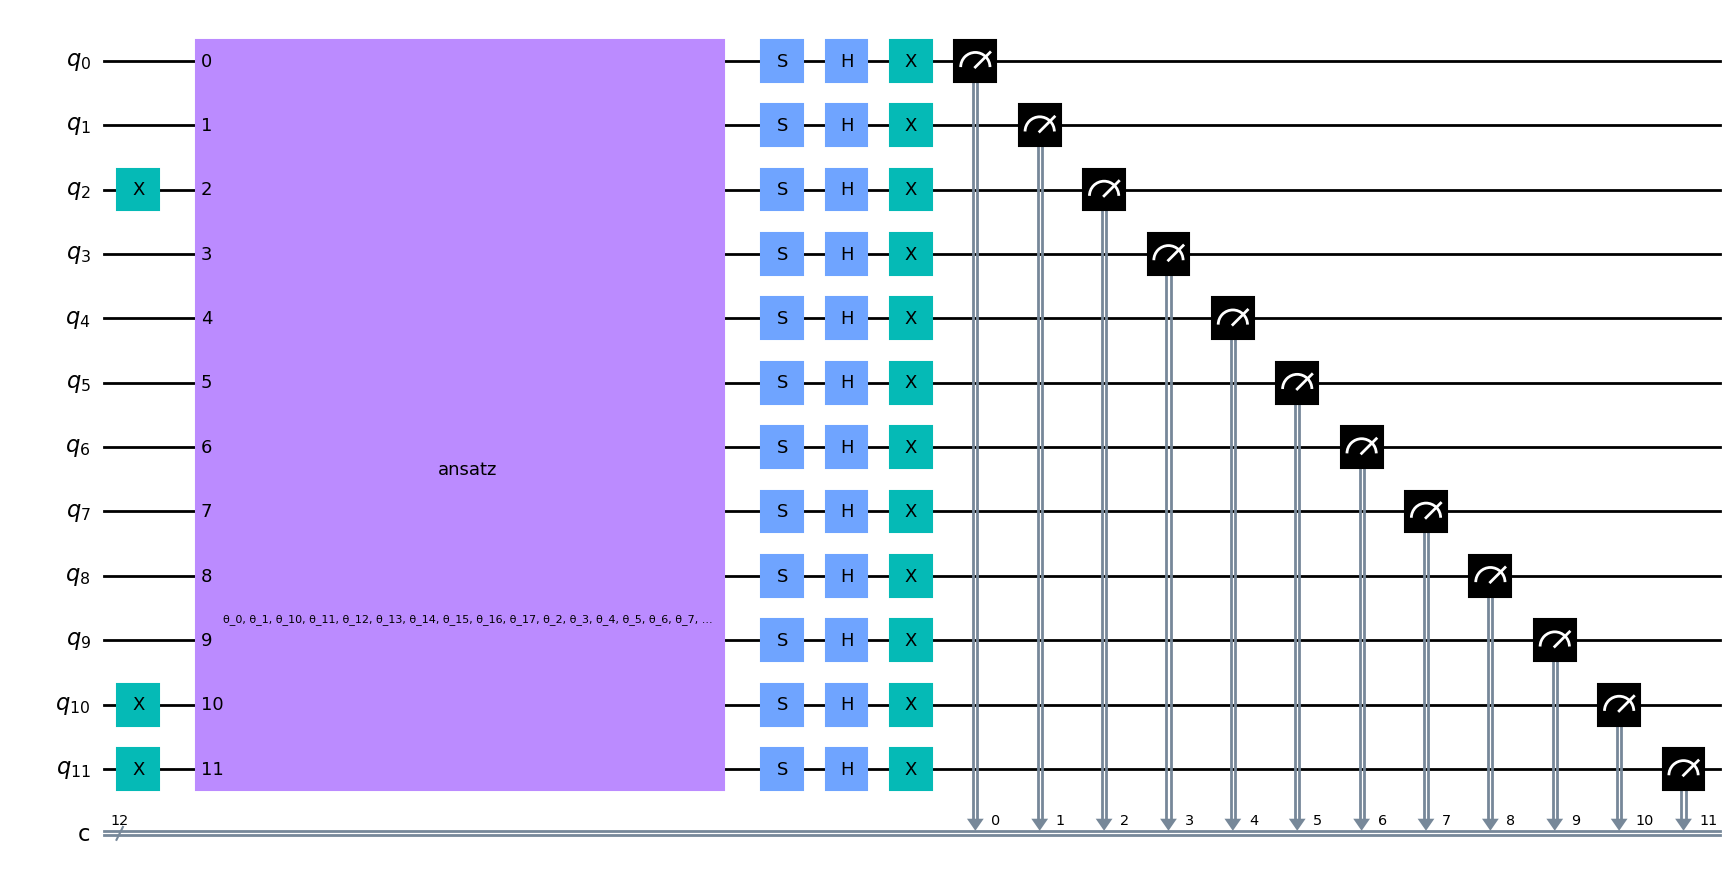

In [13]:
qcy.draw('mpl',fold=-1)

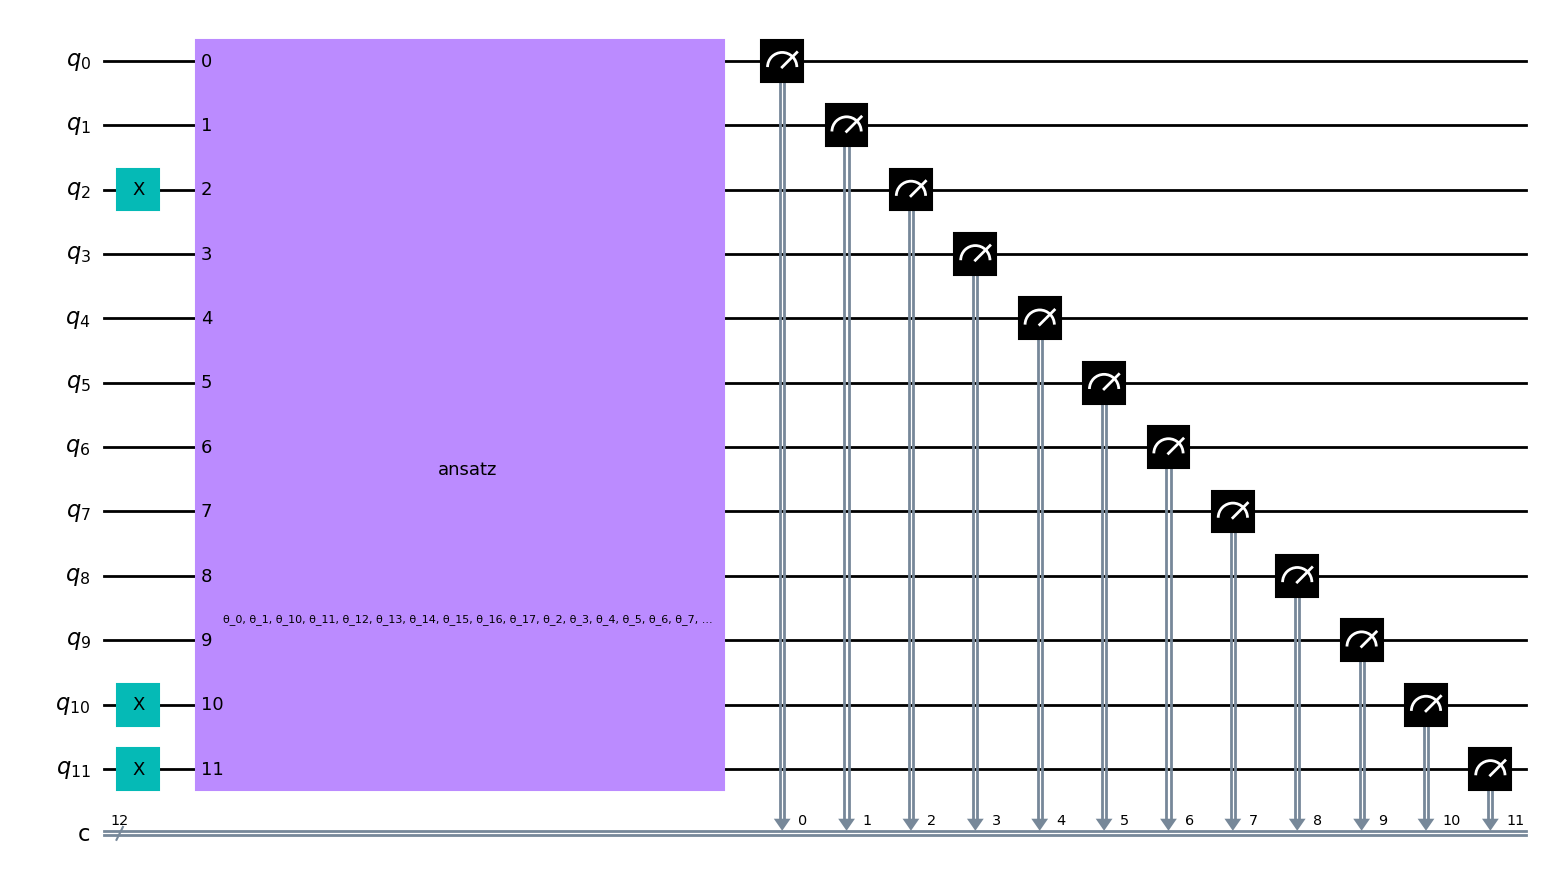

In [14]:
qcz.draw('mpl',fold=-1)

In order to make this circuits more accessible, we implemented a class object that contains all of them and more relevant parameters of the system. In the rest of the scripts it is imported from kagome_custom.py

In [15]:
class custom_VQE():
    
    def __init__(self, edge_list, num_qubits, layers, shots):
        self.edge_list = edge_list
        self.num_qubits = num_qubits
        self.layers = layers
        self.shots = shots
        self.down_list = [11,10,2]
        self.num_param = 3*self.layers
        
        self.get_backend()
        self.setup_circuit()
        self.add_init_state()
        self.build_ansatz()
        self.add_ansatz()
        self.build_measure_circuits()
        
        graph = rx.PyGraph(multigraph=False)
        graph.add_nodes_from(range(self.num_qubits))
        graph.add_edges_from(self.edge_list)

        self.kagome_unit_cell = Lattice(graph)
        
        self.estimator = Estimator()
        heis = HeisenbergModel.uniform_parameters(lattice=self.kagome_unit_cell,uniform_interaction=1.0,uniform_onsite_potential=0.0)
        log_mapper = LogarithmicMapper()
        self.ham = 4*log_mapper.map(heis.second_q_ops().simplify())

        
       
    
    def plot_lattice(self):
        kagome_pos = {0:[0,6.8], 6:[0.6,5], 9:[1.8,5.1], 
                      1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
                      11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
                      8:[-1.8,5.1], 7:[1.8,0.9]}
        self.kagome_unit_cell.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':kagome_pos})
        plt.show()
        
    
    def exact_gs_energy(self):
        exact_solver = NumPyEigensolver(k=3)
        exact_result = exact_solver.compute_eigenvalues(self.ham)

        self.gs_energy = np.round(exact_result.eigenvalues[0], 4)
        print('Exact ground state energ: ' + str(self.gs_energy))
        
        
    
    
    # ----------------------- Basic quantum circuit setup ---------------------------
    def setup_circuit(self):
        self.qc = QuantumCircuit(self.num_qubits, self.num_qubits)
    
    def add_init_state(self):
        for i in self.down_list:
            self.qc.x(i)
             
    def add_edge_gates(self,qa,edge,var,p):
        [n1, n2] = [edge[0],edge[1]]
        
        phi = self.param[var+3*p]
     
        if var == 0:
            qa.rxx(phi,n1,n2)
        elif var == 1:
            qa.ryy(phi,n1,n2)
        else :
            qa.rzz(phi,n1,n2)

    def build_ansatz(self):
        self.param = []
        for k in range(self.num_param):
            self.param.append(Parameter('θ_' + str(k)))

        self.ansatz = QuantumCircuit(self.num_qubits,name='ansatz')
        
        self.ansatz.barrier()
        for k in range(self.layers):
            for i in range(3):
                for edge in self.edge_list:
                    self.ansatz.barrier()
                    self.add_edge_gates(self.ansatz,edge,i,k)
        self.ansatz.barrier()
        
    def add_ansatz(self):
        self.qc.append(self.ansatz, range(self.num_qubits))

  
            
    # ---------------- Measurement and energy evaluation ----------------- 
    def get_backend(self):
        self.aer_sim = Aer.get_backend('aer_simulator')
    
    def build_measure_circuits(self):
        self.qc_meas = [None, None, None]
        for j in range(3):
            self.qc_meas[j] = self.qc.copy()
            for i in range(self.num_qubits):
                if j == 0:
                    self.qc_meas[j].h(i)

                elif j == 1:
                    self.qc_meas[j].s(i)
                    self.qc_meas[j].h(i)
                    self.qc_meas[j].x(i)
                    
                    

                self.qc_meas[j].measure(i,i)
                

In [16]:
t = 1.0
edge_list = [
    (1, 2, t),
    (2, 3, t),
    (3, 5, t),
    (5, 8, t),
    (8, 11, t),
    (11, 0, t),
    (0, 6, t),
    (6, 9, t),
    (9, 10, t),
    (10, 7, t),
    (7, 4, t),
    (4, 1, t),
    (4, 2, t),
    (2, 5, t),
    (5, 11, t),
    (11, 6, t),
    (6, 10, t),
    (10, 4, t),
]
num_qubits = 12
layers = 6
shots = 1000

kagome = custom_VQE(edge_list, num_qubits, layers, shots)  

We desingned the next energy calculation to make it independent of the axis, thus being parallelizable.


In [17]:
def get_energy(vqe,circuit):
        
        results = vqe.aer_sim.run(circuit,shots=vqe.shots).result()
        counts = results.get_counts()
        
        energy = 0
        for edge in vqe.edge_list:
            for num in counts:
                factor = 1
                for n in range(len(num)):
                    n_corr = len(num) - n - 1
                    digit = int(num[n_corr])
                    if n == edge[0] or n == edge[1]:
                        if digit == 1:
                            factor *= -1
                energy += factor*counts[num]

        energy = energy/vqe.shots
        return energy
    
def energy_estimation(vqe,param):
        transpiled_qc_meas = [None, None, None]
        for j in range(3):
            transpiled_qc_meas[j] = vqe.qc_meas[j].assign_parameters(param)
            transpiled_qc_meas[j] = transpile(transpiled_qc_meas[j],vqe.aer_sim)
        
  
        energies = [None,None,None]
        for axis in range(3):
            energies[axis] = get_energy(vqe,transpiled_qc_meas[axis])

        energy_tot = sum(energies)
        return energy_tot

In [18]:
energy_estimation(kagome,[0]*18) # Ising model's ground state energy  estimation

-6.068

The standard deviation of the energy from a shot simulation is:


$sd = \frac{E_{real}}{\sqrt{shots}}$


As the exact value of the energy in this case is -6.0, we have the next standard deviation:

In [19]:
print(6.0/np.sqrt(shots))

0.18973665961010278


### Differential Evolution

In [20]:
# Guardar energías anterior iteración
@dask.delayed
def binomial(vqe,npop,population,num_p,cr,f):
    
        x = population[npop]
               
        valid_index = [ind for ind in range(num_p) if ind != npop]
    
        cross_index = np.random.choice(valid_index, 3, replace = False)

        a = population[cross_index[0]]
        #a = best_param
        
        b = population[cross_index[1]]
        c = population[cross_index[2]]
        r = np.random.randint(0,vqe.num_param)
        y = np.array([])

        for yi in range(vqe.num_param):
            ri = np.random.uniform(0,1)
            if ri < cr or yi == r:
                y = np.append(y,(a[yi] + f * (b[yi] - c[yi]))%(np.pi))
            else :
                y = np.append(y,x[yi])
        
        ener_y = energy_estimation(vqe,y)
        ener_x = energy_estimation(vqe,x)
        
        best = []
        if ener_y < ener_x:
            best = [y,ener_y]
            
        else :
            best = [x,ener_x] 

        return best
      
@dask.delayed
def exponential(vqe,npop,population,num_p,cr,f):
    
        x = population[npop]
               
        valid_index = [ind for ind in range(num_p) if ind != npop]
    
        cross_index = np.random.choice(valid_index, 3, replace = False)

        a = population[cross_index[0]]
        #a = best_param
        b = population[cross_index[1]]
        c = population[cross_index[2]]
        r = np.random.randint(0,vqe.num_param)
        y = [0]*vqe.num_param
        
        for yi in range(vqe.num_param):
            y[yi]=x[yi]
        exp_index = np.random.choice(range(0,vqe.num_param-1), 2, replace = False)
        exp_index = np.sort(exp_index)
        
        for yi in range(exp_index[0],exp_index[1]+1):
                y[yi] = (a[yi] + f * (b[yi] - c[yi]))%(np.pi)
                

        ener_y = energy_estimation(vqe,y)
        ener_x = vqe.population_energies[npop]
          
        
        best = []
        if ener_y < ener_x:
            best = [y,ener_y]
            
        else :
            best = [x,ener_x] 

        return best
        
    

In [31]:
def diff_ev(vqe, init_param, itmax=10, num_p=20, cr=0.9, f=0.8):
        
    #tol=1/np.sqrt(vqe.shots)
    old_pop = []
    for npop in range(num_p):
        old_pop.append(init_param + (-1+2*np.random.rand(vqe.num_param))*1.e-2)

    old_energy = energy_estimation(vqe,init_param)
    info = [old_energy]

    print('Energy Z-ground state: '+str(old_energy))
    print()

    population = old_pop
    vqe.population_energies = []
    for npop in range(num_p):
        vqe.population_energies.append(0)

    for npop in range(num_p):
        vqe.population_energies[npop] = energy_estimation(vqe,population[npop])

    best_energy = old_energy

    file_name = 'results85.txt'
    file=open(file_name, 'w')
    file.close()

    for it in range(itmax):
        print('-----Iteration '+str(it+1)+'-----')

        cond_list = []
        for npop in range(num_p):
            cond_list.append(None)


        for npop in range(num_p):
            cond_list[npop] = exponential(vqe,npop,population,num_p,cr,f) #####

        cond_list = dask.compute(cond_list)
        cond_list = cond_list[0]


        for npop in range(num_p):
            population[npop] = cond_list[npop][0]
            vqe.population_energies[npop] = cond_list[npop][1]


        for indv in range(len(population)):
            indv_energy = vqe.population_energies[indv]

            if indv_energy < best_energy:
                best_energy = indv_energy


        print(best_energy)



        file = open(file_name,'a')
        file.writelines(str(best_energy)+'\n')
        file.close()

# Stoping criteria
#         if np.std(vqe.population_energies) < tol * np.abs(np.mean(vqe.population_energies)):
#             print('convergence')
#             break     


    return population

In [33]:
#path_to_json = './scheduler_info.json' # Change to compute with FT3
#client = Client(scheduler_file = path_to_json)
client = Client(n_workers=12)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:64682/status,
Dashboard: http://127.0.0.1:64682/status,Workers: 12
Total threads: 12,Total memory: 15.91 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:64683,Workers: 12
Dashboard: http://127.0.0.1:64682/status,Total threads: 12
Started: Just now,Total memory: 15.91 GiB
Comm: tcp://127.0.0.1:64750,Total threads: 1
Dashboard: http://127.0.0.1:64757/status,Memory: 1.33 GiB
Nanny: tcp://127.0.0.1:64686,


In [ ]:
init_param = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
values = diff_ev(kagome,init_param)

Energy Z-ground state: -5.832

